# Downloading data

In [1]:
import torch
import yfinance as yf

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder
from models.fama_french import FamaFrench

# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import json
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Optimisation
from pypfopt.expected_returns import mean_historical_return
from pypfopt.hierarchical_portfolio import HRPOpt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0);

In [2]:
# 2 years training (split into 2 year train and 1 year valid), 18 months test
start_date = '2017-03-01'
valid_date = '2019-03-01'
train_date = '2020-03-01'
end_date   = '2021-09-01'

# Open json file with parameters
with open(f'params/sp500_{start_date}.json') as f:
    params = json.load(f)

In [ ]:
# Download data
data_dict = {'Linear': {}, 'CNN': {}, 'Linear + CNN': {}}
for model in ['Linear', 'CNN', 'Linear + CNN']:
    data_arrays, price_dfs = utils.split_data(start_date, valid_date, train_date, end_date, train_valid_split=2 / 3, **params[model]['sharpe']['data'])
    data_dict[model]['data_train'] = data_arrays[0]
    assert np.isnan(data_arrays[0]).sum() == 0

prices_train = price_dfs[0]
prices_test = price_dfs[3]

num_epochs=20

In [3]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end=end_date, period="1d")['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

[*********************100%***********************]  1 of 1 completed


# Calculating autoencoder distance matrix

In [4]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_dict['Linear']['data_train'].shape[1], num_epochs=num_epochs, data=data_dict['Linear']['data_train'], verbose=True, **params['Linear']['sharpe']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_dict['CNN']['data_train'].shape[1], num_epochs=num_epochs, data=data_dict['CNN']['data_train'], verbose=True, **params['CNN']['sharpe']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_dict['Linear + CNN']['data_train'].shape[1], num_epochs=num_epochs, data=data_dict['Linear + CNN']['data_train'], verbose=True, **params['Linear + CNN']['sharpe']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.0683
Epoch [2/20], Loss: 0.0199
Epoch [3/20], Loss: 0.0161
Epoch [4/20], Loss: 0.0138
Epoch [5/20], Loss: 0.0126
Epoch [6/20], Loss: 0.0118
Epoch [7/20], Loss: 0.0110
Epoch [8/20], Loss: 0.0102
Epoch [9/20], Loss: 0.0097
Epoch [10/20], Loss: 0.0091
Epoch [11/20], Loss: 0.0085
Epoch [12/20], Loss: 0.0081
Epoch [13/20], Loss: 0.0077
Epoch [14/20], Loss: 0.0074
Epoch [15/20], Loss: 0.0074
Epoch [16/20], Loss: 0.0071
Epoch [17/20], Loss: 0.0068
Epoch [18/20], Loss: 0.0066
Epoch [19/20], Loss: 0.0063
Epoch [20/20], Loss: 0.0062
ConvAutoencoder
Epoch [1/20], Loss: 0.1196
Epoch [2/20], Loss: 0.0780
Epoch [3/20], Loss: 0.0670
Epoch [4/20], Loss: 0.0585
Epoch [5/20], Loss: 0.0463
Epoch [6/20], Loss: 0.0384
Epoch [7/20], Loss: 0.0305
Epoch [8/20], Loss: 0.0256
Epoch [9/20], Loss: 0.0213
Epoch [10/20], Loss: 0.0192
Epoch [11/20], Loss: 0.0176
Epoch [12/20], Loss: 0.0163
Epoch [13/20], Loss: 0.0158
Epoch [14/20], Loss: 0.0155
Epoch [15/20], Loss: 0.0152
Epoc

In [5]:
%%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
    print(model)
    learner = AutoWarp(models[model], data_dict[model]['data_train'], **params[model]['sharpe']['dist_matrix'])
    learner.learn_metric(verbose=True)
    dist_matrices[model] = learner.create_distance_matrix()

Linear
Alpha: 0.313399076461792
Gamma: 0.5823413729667664
Epsilon: 0.3877143859863281
Linear + CNN
Alpha: 0.8519362211227417
Gamma: 0.012225627899169922
Epsilon: 0.5021201372146606
CNN
Alpha: 0.3991110920906067
Gamma: 0.18592149019241333
Epsilon: 0.5591468811035156
CPU times: total: 3min
Wall time: 38.1 s


In [6]:
# learner = AutoWarp(models[model], data_train, **params['Linear + CNN']['sharpe']['dist_matrix'])
# learner.euclidian_distance()

# Mean variance optimisation

In [7]:
# Empty dict for weights
weights = {}

for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['sharpe']['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, "train SR:", train_sr)

for model in ["Covariance", "Covariance Shrinkage", "EW Covariance"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, "train SR:", train_sr)

# Factor model
e_returns = mean_historical_return(prices_train)
optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='ECOS', weight_bounds = (0,1)) # Using ECOS as OSQP is a bit temperamental for Fama-French
fama_french = FamaFrench(prices_train, file_path='data/F-F_Research_Data_Factors_daily.CSV', n_rows=25419)
fama_cov = fama_french.get_covariance_matrix()
weights['Fama-French 3 factor'], train_sr = optimiser.max_sharpe_ratio(risk_matrix=fama_cov, l2_reg=0)
print("Fama-French 3 factor train SR:", train_sr)

# HRP
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize()
weights['HRP'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])
train_sr = utils.calculate_sharpe_ratio(prices = prices_test, weights = weights['HRP'])
print("HRP train SR:", train_sr)

# Equal weights
weights['Equal'] = weights['Linear'].copy()
weights['Equal']['weights'] = 1/weights['Linear']['weights'].shape[0]
print("Equal train SR:", utils.calculate_sharpe_ratio(weights=weights['Equal'], prices=prices_train))

Linear 1.4854092337336697
CNN 1.598299184629587
Linear + CNN 1.5904848132131586
Covariance 1.940722525308926
Covariance Shrinkage 1.9380257264987268
EW Covariance 1.7056880124309861
Fama-French 3 factor 1.6334042881848916
HRP 0.9459648705799084
Equal 0.6815761368153698


# Evaulating performance on the test set

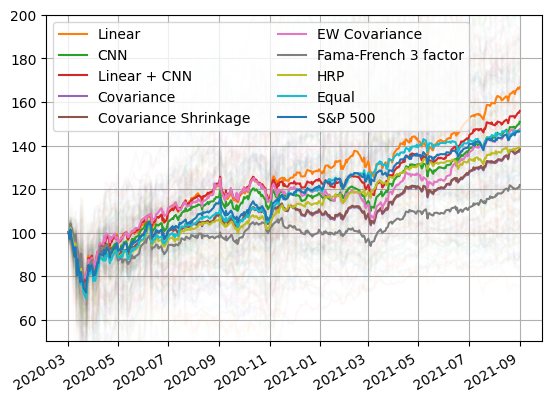

In [17]:
# Plots
plt.plot(prices_test, alpha=0.025)
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.grid()
plt.gcf().autofmt_xdate()
plt.legend(ncol=2);

In [18]:
# Sharpe ratio for each model
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model]))

Linear sharpe 1.2783086287382586
CNN sharpe 1.0779020838930191
Linear + CNN sharpe 1.208857559477513
Covariance sharpe 0.8710582027181031
Covariance Shrinkage sharpe 0.8794455917327677
EW Covariance sharpe 1.0378495966928383
Fama-French 3 factor sharpe 0.5846830955066616
HRP sharpe 0.9459648705799084
Equal sharpe 1.0295399768029363


In [19]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "max drawdown:", utils.max_drawdown(prices_test, weights[model])*100)

Linear max drawdown: 26.36882564900652
CNN max drawdown: 29.699099135444197
Linear + CNN max drawdown: 25.36832790575934
Covariance max drawdown: 29.451845617758014
Covariance Shrinkage max drawdown: 29.41459202658442
EW Covariance max drawdown: 22.524643447082568
Fama-French 3 factor max drawdown: 31.73107994434164
HRP max drawdown: 30.923141415563126
Equal max drawdown: 31.386369366222066


In [20]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "EW Covariance", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 25
CNN number of stocks included: 19
Linear + CNN number of stocks included: 28
Covariance number of stocks included: 11
Covariance Shrinkage number of stocks included: 13
EW Covariance number of stocks included: 10
Fama-French 3 factor number of stocks included: 24
HRP number of stocks included: 181
Equal number of stocks included: 181


# Plotting all results

In [28]:
results = {}
for start_date in ["2017-03-01", "2017-09-01", "2018-03-01"]:
    results[start_date] = {}
    for opt in ['sharpe', 'volatility']:
   # Open json file with parameters
        with open(f'results/sp500_{start_date}_{opt}.json') as f:
            results[start_date][opt] = json.load(f)['sharpe_ratios']

In [29]:
# convert dict of dicts to dataframe
results_df = pd.DataFrame.from_dict({(i,j): results[i][j]
                           for i in results.keys()
                           for j in results[i].keys()},
                       orient='index')

In [34]:
# Seperate dataframe for when second index is 'sharpe' and 'volatility'
results_sharpe = results_df[results_df.index.get_level_values(1) == 'sharpe'].droplevel(1)
results_volatility = results_df[results_df.index.get_level_values(1) == 'volatility'].droplevel(1)

# Drop Equal from results_sharpe
results_sharpe = results_sharpe.drop('Equal', axis=1)

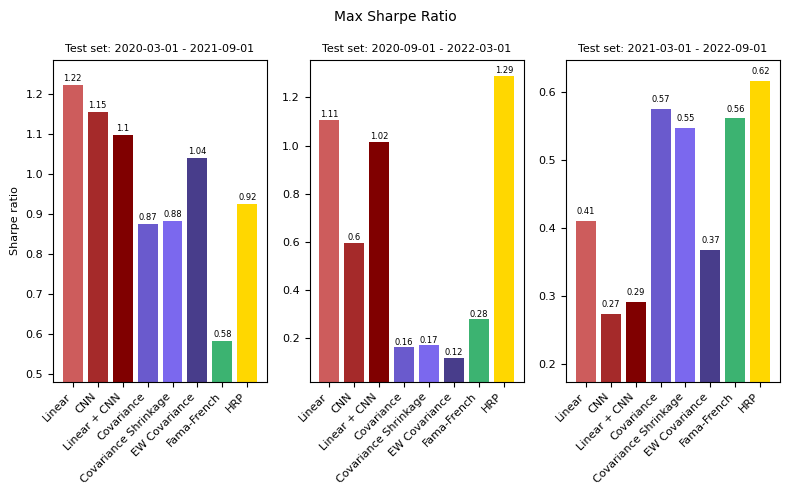

In [40]:
colours = ['indianred', 'brown', 'maroon', 'slateblue', 'mediumslateblue', 'darkslateblue', 'mediumseagreen', 'gold', 'gray']

fig, ax = plt.subplots(1, 3, figsize=(8, 5))
i=0
for date in results_sharpe.index:

    # Calculate test period
    test_start = datetime.strptime(date, '%Y-%m-%d') + relativedelta(years=3)
    test_end = test_start + relativedelta(years=1, months=6)

    # Plotting
    ax[i].bar(results_sharpe[results_sharpe.index==date].columns, np.squeeze(results_sharpe[results_sharpe.index==date].values), color = colours)
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax[i].get_yticklabels(), fontsize=8)
    min_y = np.squeeze(results_sharpe[results_sharpe.index==date].values).min()-0.1
    ax[i].set_ylim(bottom = min_y)
    ax[i].set_title(f"Test set: {test_start.strftime('%Y-%m-%d')} - {test_end.strftime('%Y-%m-%d')}", fontsize = 8)

    # Add values to bars
    for j, v in enumerate(np.squeeze(results_sharpe[results_sharpe.index==date].values)):
        ax[i].text(j, v+0.01, str(round(v, 2)), color='black', fontsize=6, ha='center')

    i+=1

ax[0].set_ylabel('Sharpe ratio', fontsize=8)

fig.suptitle('Max Sharpe Ratio', fontsize=10)
fig.tight_layout();

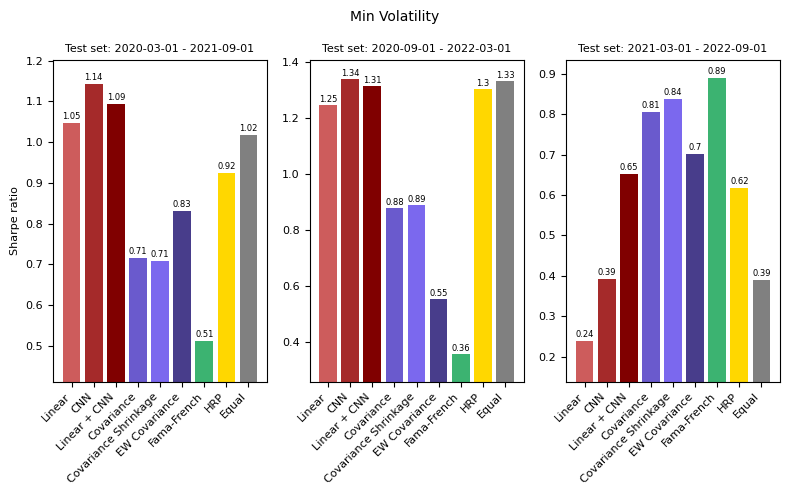

In [41]:
colours = ['indianred', 'brown', 'maroon', 'slateblue', 'mediumslateblue', 'darkslateblue', 'mediumseagreen', 'gold', 'gray']

fig, ax = plt.subplots(1, 3, figsize=(8, 5))
i=0
for date in results_volatility.index:

    # Calculate test period
    test_start = datetime.strptime(date, '%Y-%m-%d') + relativedelta(years=3)
    test_end = test_start + relativedelta(years=1, months=6)

    # Plotting
    ax[i].bar(results_volatility[results_volatility.index==date].columns, np.squeeze(results_volatility[results_volatility.index==date].values), color = colours)
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax[i].get_yticklabels(), fontsize=8)
    min_y = np.squeeze(results_volatility[results_volatility.index==date].values).min()-0.1
    ax[i].set_ylim(bottom = min_y)
    ax[i].set_title(f"Test set: {test_start.strftime('%Y-%m-%d')} - {test_end.strftime('%Y-%m-%d')}", fontsize = 8)

    # Add values to bars
    for j, v in enumerate(np.squeeze(results_volatility[results_volatility.index==date].values)):
        ax[i].text(j, v+0.01, str(round(v, 2)), color='black', fontsize=6, ha='center')

    i+=1

ax[0].set_ylabel('Sharpe ratio', fontsize=8)

fig.suptitle('Min Volatility', fontsize=10)
fig.tight_layout();